## OpenAlex API data gathering


In [114]:
# imports
from pyalex import Works, Authors, Sources, Institutions, Topics, Publishers, Funders, config
import pandas as pd
import json
from pathlib import Path
import time
import os
import matplotlib.pyplot as plt

In [2]:
# config
config.email = "thoc@itu.dk"
config.max_retries = 0
config.retry_backoff_factor = 0.1
config.retry_http_codes = [429, 500, 503]

In [3]:
# filter works by institution country code
us_data = Works().filter(institutions = {"country_code": [ "US"]}).get()
eu_data = Works().filter(institutions = {"country_code": [ "AT|BE|BG|HR|CY|CZ|DK|EE|FI|FR|DE|GR|HU|IE|IT|LV|LT|LU|MT|NL|PL|PT|RO|SK|SI|ES|SE"]}).get()

In [4]:
# metadata for the datasets
print(us_data.meta)
print(eu_data.meta)

{'count': 30751123, 'db_response_time_ms': 131, 'page': 1, 'per_page': 25, 'groups_count': None}
{'count': 28266650, 'db_response_time_ms': 278, 'page': 1, 'per_page': 25, 'groups_count': None}


In [6]:
attribute_list = []
for item in us_data[0].keys():
    attribute_list.append(item)

In [ ]:
#all accessible attributes of work objects in list format for reference
attribute_list

['id',
 'doi',
 'title',
 'display_name',
 'publication_year',
 'publication_date',
 'ids',
 'language',
 'primary_location',
 'type',
 'type_crossref',
 'indexed_in',
 'open_access',
 'authorships',
 'institution_assertions',
 'countries_distinct_count',
 'institutions_distinct_count',
 'corresponding_author_ids',
 'corresponding_institution_ids',
 'apc_list',
 'apc_paid',
 'fwci',
 'has_fulltext',
 'fulltext_origin',
 'cited_by_count',
 'citation_normalized_percentile',
 'cited_by_percentile_year',
 'biblio',
 'is_retracted',
 'is_paratext',
 'primary_topic',
 'topics',
 'keywords',
 'concepts',
 'mesh',
 'locations_count',
 'locations',
 'best_oa_location',
 'sustainable_development_goals',
 'grants',
 'datasets',
 'versions',
 'referenced_works_count',
 'referenced_works',
 'related_works',
 'abstract_inverted_index',
 'cited_by_api_url',
 'counts_by_year',
 'updated_date',
 'created_date']

In [18]:
# print paper first author name, canonical id, name, doi and publication year
print(us_data[0]['authorships'][0]["author"]["display_name"])
print(us_data[0]["id"])
print(us_data[0]["doi"])
print(us_data[0]["title"])
print(us_data[0]["publication_date"])
# maybe filter by amount of citations to ensure we don't get nonsense?
print(us_data[0]["cited_by_count"])
# different topics?
print(us_data[0]["primary_topic"]["domain"]["display_name"])

OliverH. Lowry
https://openalex.org/W1775749144
https://doi.org/10.1016/s0021-9258(19)52451-6
PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT
1951-11-01
321309
Life Sciences


In [23]:
print(us_data[3]['authorships'][0]["author"])

{'id': 'https://openalex.org/A5014987686', 'display_name': 'John P. Perdew', 'orcid': 'https://orcid.org/0000-0003-4237-824X'}


In [ ]:
# create list of presidential terms from gemini
PRESIDENTIAL_TERMS = [
    {"president": "George Washington", "start_date": "1789-04-30", "end_date": "1797-03-04"},
    {"president": "John Adams", "start_date": "1797-03-04", "end_date": "1801-03-04"},
    {"president": "Thomas Jefferson", "start_date": "1801-03-04", "end_date": "1809-03-04"},
    {"president": "James Madison", "start_date": "1809-03-04", "end_date": "1817-03-04"},
    {"president": "James Monroe", "start_date": "1817-03-04", "end_date": "1825-03-04"},
    {"president": "John Quincy Adams", "start_date": "1825-03-04", "end_date": "1829-03-04"},
    {"president": "Andrew Jackson", "start_date": "1829-03-04", "end_date": "1837-03-04"},
    {"president": "Martin Van Buren", "start_date": "1837-03-04", "end_date": "1841-03-04"},
    {"president": "William Henry Harrison", "start_date": "1841-03-04", "end_date": "1841-04-04"}, # Died in office
    {"president": "John Tyler", "start_date": "1841-04-04", "end_date": "1845-03-04"}, # Finished Harrison's term
    {"president": "James K. Polk", "start_date": "1845-03-04", "end_date": "1849-03-04"},
    {"president": "Zachary Taylor", "start_date": "1849-03-04", "end_date": "1850-07-09"}, # Died in office
    {"president": "Millard Fillmore", "start_date": "1850-07-09", "end_date": "1853-03-04"}, # Finished Taylor's term
    {"president": "Franklin Pierce", "start_date": "1853-03-04", "end_date": "1857-03-04"},
    {"president": "James Buchanan", "start_date": "1857-03-04", "end_date": "1861-03-04"},
    {"president": "Abraham Lincoln", "start_date": "1861-03-04", "end_date": "1865-04-15"}, # Assassinated
    {"president": "Andrew Johnson", "start_date": "1865-04-15", "end_date": "1869-03-04"}, # Finished Lincoln's term
    {"president": "Ulysses S. Grant", "start_date": "1869-03-04", "end_date": "1877-03-04"},
    {"president": "Rutherford B. Hayes", "start_date": "1877-03-04", "end_date": "1881-03-04"},
    {"president": "James A. Garfield", "start_date": "1881-03-04", "end_date": "1881-09-19"}, # Assassinated
    {"president": "Chester A. Arthur", "start_date": "1881-09-19", "end_date": "1885-03-04"}, # Finished Garfield's term
    {"president": "Grover Cleveland", "start_date": "1885-03-04", "end_date": "1889-03-04"}, # First term
    {"president": "Benjamin Harrison", "start_date": "1889-03-04", "end_date": "1893-03-04"},
    {"president": "Grover Cleveland", "start_date": "1893-03-04", "end_date": "1897-03-04"}, # Second, non-consecutive term
    {"president": "William McKinley", "start_date": "1897-03-04", "end_date": "1901-09-14"}, # Assassinated
    {"president": "Theodore Roosevelt", "start_date": "1901-09-14", "end_date": "1909-03-04"}, # Finished McKinley's term + elected term
    {"president": "William Howard Taft", "start_date": "1909-03-04", "end_date": "1913-03-04"},
    {"president": "Woodrow Wilson", "start_date": "1913-03-04", "end_date": "1921-03-04"},
    {"president": "Warren G. Harding", "start_date": "1921-03-04", "end_date": "1923-08-02"}, # Died in office
    {"president": "Calvin Coolidge", "start_date": "1923-08-02", "end_date": "1929-03-04"}, # Finished Harding's term + elected term
    {"president": "Herbert Hoover", "start_date": "1929-03-04", "end_date": "1933-03-04"},
    {"president": "Franklin D. Roosevelt", "start_date": "1933-03-04", "end_date": "1945-04-12"}, # Died during 4th term
    {"president": "Harry S. Truman", "start_date": "1945-04-12", "end_date": "1953-01-20"}, # Finished FDR's term + elected term
    {"president": "Dwight D. Eisenhower", "start_date": "1953-01-20", "end_date": "1961-01-20"},
    {"president": "John F. Kennedy", "start_date": "1961-01-20", "end_date": "1963-11-22"}, # Assassinated
    {"president": "Lyndon B. Johnson", "start_date": "1963-11-22", "end_date": "1969-01-20"}, # Finished JFK's term + elected term
    {"president": "Richard Nixon", "start_date": "1969-01-20", "end_date": "1974-08-09"}, # Resigned
    {"president": "Gerald Ford", "start_date": "1974-08-09", "end_date": "1977-01-20"}, # Finished Nixon's term
    {"president": "Jimmy Carter", "start_date": "1977-01-20", "end_date": "1981-01-20"},
    {"president": "Ronald Reagan", "start_date": "1981-01-20", "end_date": "1989-01-20"},
    {"president": "George H.W. Bush", "start_date": "1989-01-20", "end_date": "1993-01-20"},
    {"president": "Bill Clinton", "start_date": "1993-01-20", "end_date": "2001-01-20"},
    {"president": "George W. Bush", "start_date": "2001-01-20", "end_date": "2009-01-20"},
    {"president": "Barack Obama", "start_date": "2009-01-20", "end_date": "2017-01-20"},
    {"president": "Donald Trump", "start_date": "2017-01-20", "end_date": "2021-01-20"},
    {"president": "Joe Biden", "start_date": "2021-01-20", "end_date": "2025-01-20"} # Current term end date    
]

# add current trump presidency

In [ ]:
# Adds term number to list of dicts
print(len(PRESIDENTIAL_TERMS))
for i in range(len(PRESIDENTIAL_TERMS)):
    PRESIDENTIAL_TERMS[i]["term"] = i+1
print(PRESIDENTIAL_TERMS)

46
[{'president': 'George Washington', 'start_date': '1789-04-30', 'end_date': '1797-03-04', 'term': 1}, {'president': 'John Adams', 'start_date': '1797-03-04', 'end_date': '1801-03-04', 'term': 2}, {'president': 'Thomas Jefferson', 'start_date': '1801-03-04', 'end_date': '1809-03-04', 'term': 3}, {'president': 'James Madison', 'start_date': '1809-03-04', 'end_date': '1817-03-04', 'term': 4}, {'president': 'James Monroe', 'start_date': '1817-03-04', 'end_date': '1825-03-04', 'term': 5}, {'president': 'John Quincy Adams', 'start_date': '1825-03-04', 'end_date': '1829-03-04', 'term': 6}, {'president': 'Andrew Jackson', 'start_date': '1829-03-04', 'end_date': '1837-03-04', 'term': 7}, {'president': 'Martin Van Buren', 'start_date': '1837-03-04', 'end_date': '1841-03-04', 'term': 8}, {'president': 'William Henry Harrison', 'start_date': '1841-03-04', 'end_date': '1841-04-04', 'term': 9}, {'president': 'John Tyler', 'start_date': '1841-04-04', 'end_date': '1845-03-04', 'term': 10}, {'presid

In [ ]:
# Final Presidential
print(PRESIDENTIAL_TERMS[40:][0])
UPDATED_PRESIDENTIAL_TERMS = PRESIDENTIAL_TERMS[40:]

In [ ]:
# date filtering by presidential term for Barack Obama
test_data = Works() \
.filter(institutions = {"country_code": [ "US"]}) \
.filter(from_publication_date = "2009-01-20") \
.filter(to_publication_date = "2017-01-20") \
.get()


In [ ]:
# Create json files for all US papers released in each presidential term and put them in a folder
os.makedirs("US_data", exist_ok=True)
for i, term in enumerate(PRESIDENTIAL_TERMS):
    with open(Path(f"US_data/{i}_{term["president"]}.json"), "w") as f:
        data = Works() \
        .filter(institutions = {"country_code": ["US"]}) \
        .filter(from_publication_date = term["start_date"]) \
        .filter(to_publication_date = term["end_date"]) \
        .get()
        json.dump(data, f)
        time.sleep(0.5)

In [ ]:
# Create json files for all EU papers released in each presidential term and put them in a folder
os.makedirs("EU_data", exist_ok=True)
for i, term in enumerate(PRESIDENTIAL_TERMS):
    with open(Path(f"EU_data/{i}_{term["president"]}.json"), "w") as f:
        data = Works() \
        .filter(institutions = {"country_code": ["AT|BE|BG|HR|CY|CZ|DK|EE|FI|FR|DE|GR|HU|IE|IT|LV|LT|LU|MT|NL|PL|PT|RO|SK|SI|ES|SE"]}) \
        .filter(from_publication_date = term["start_date"]) \
        .filter(to_publication_date = term["end_date"]) \
        .get()
        json.dump(data, f)
        time.sleep(0.5)

#### next step: Write a CSV/pandas dataframe using the below code with only information we want and find a way to structure it so its easily searcheable 

In [ ]:
# iterate through the work object and add these to a df then save as csv for easier imports and transformation using pandas
us_data[0]['authorships'][0]["author"]["display_name"]
us_data[0]["id"]
us_data[0]["doi"]
us_data[0]["title"]
us_data[0]["publication_date"]
us_data[0]["cited_by_count"]
us_data[0]["primary_topic"]["domain"]["display_name"]
us_data[0]["publication_data"]

1951

### Mock data for testing csv creation

In [31]:
print(PRESIDENTIAL_TERMS[40]["president"])
print(PRESIDENTIAL_TERMS[40]["term"])
term = PRESIDENTIAL_TERMS[40]
data = Works() \
        .filter(institutions = {"country_code": ["AT|BE|BG|HR|CY|CZ|DK|EE|FI|FR|DE|GR|HU|IE|IT|LV|LT|LU|MT|NL|PL|PT|RO|SK|SI|ES|SE"]}) \
        .filter(from_publication_date = term["start_date"]) \
        .filter(to_publication_date = term["end_date"]) \
        .get()

George H.W. Bush
41


In [36]:
# csv header proposal
columns = ["id","doi","title", "author", "date", "citations", "topic", "term"]
df = pd.DataFrame(columns = columns)

In [ ]:
#data = region_president_number 
for i in range(len(data)):
    df.loc[i] = [ \
    data[i]["id"], \
    data[i]["doi"], \
    data[i]["title"], \
    data[i]['authorships'][0]["author"]["display_name"], \
    data[i]["publication_date"], \
    data[i]["cited_by_count"], \
    data[i]["primary_topic"]["domain"]["display_name"], \
    term["term"] , \
    ] 
df

### Actual code for writing csv

In [89]:
columns = ["id","doi","title", "author", "date", "citations", "topic", "term"]
us_data_csv = pd.DataFrame(columns = columns)

In [90]:
# tracker to keep count of lines for loc
tracker = 0
for term in UPDATED_PRESIDENTIAL_TERMS:
        data = Works() \
        .filter(institutions = {"country_code": ["US"]}) \
        .filter(from_publication_date = term["start_date"]) \
        .filter(to_publication_date = term["end_date"]) \
        .paginate()
        
        # sleep to make sure we don't get too many 429 errors for calling the api too fast
        time.sleep(0.5)

        for page in data:
                for i in range(len(page)):
                        # Primary topic is sometimes missing, assign "N/A" to it if this is the case
                        primary_topic = page[i].get("primary_topic")
                        if primary_topic and primary_topic.get("domain"):
                                category = primary_topic["domain"]["display_name"]
                        else:
                                category = "N/A" # Default value when primary_topic is missing
                        
                        us_data_csv.loc[i + tracker] = [ \
                        page[i]["id"], \
                        page[i]["doi"], \
                        page[i]["title"], \
                        page[i]['authorships'][0]["author"]["display_name"], \
                        page[i]["publication_date"], \
                        page[i]["cited_by_count"], \
                        category, \
                        term["term"] , \
                        ]
                
                tracker += i
                time.sleep(0.5)      



KeyboardInterrupt: 

In [85]:
us_data_csv

,id,doi,title,author,date,citations,topic,term
0,https://openalex.org/W4254615846,https://doi.org/10.1098/rstl.1793.0010,IX. Account of two instances of uncommon forma...,John Abernethy,1793-12-31,172,Health Sciences,1
1,https://openalex.org/W2503286343,https://doi.org/10.1093/oseo/instance.00040499,Thoughts and Details on Scarcity 1795,Edmund Burke,1797-01-01,42,Physical Sciences,1
2,https://openalex.org/W4206193759,https://doi.org/10.1098/rstl.1795.0005,III. On the nature and construction of the sun...,William Herschel,1795-12-31,31,Physical Sciences,1
3,https://openalex.org/W4236183733,https://doi.org/10.1098/rstl.1795.0008,"VI. Experiments on the nerves, particularly on...",William Cumberland Cruikshank,1795-12-31,26,Health Sciences,1
4,https://openalex.org/W4248437355,https://doi.org/10.1098/rstl.1792.0011,VIII. Observations on bees,John Hunter,1792-12-31,22,Life Sciences,1
...,...,...,...,...,...,...,...,...
8314,https://openalex.org/W2500628488,https://doi.org/10.5962/bhl.title.39696,Catalogue of the Orthoptera of North America d...,Samuel H. Scudder,1868-01-01,8,Life Sciences,17
8315,https://openalex.org/W1575670551,https://doi.org/10.1080/14786446808640039,"XIX. <i>On geological time, and the probable d...",James Croll,1868-08-01,7,Physical Sciences,17
8316,https://openalex.org/W2028782997,https://doi.org/10.1007/bf02134627,Zwei Fälle von Hygroma colli cysticum congenit...,Julius Arnold,1865-06-01,7,Health Sciences,17
8317,https://openalex.org/W2041179944,https://doi.org/10.1098/rspl.1865.0050,II. On the application of physiological tests ...,C. Hilton Fagge,1865-12-31,7,Health Sciences,17


In [145]:
data = Works() \
        .filter(institutions = {"country_code": ["US"]}) \
        .filter(from_publication_date = "1989-01-20") \
        .filter(to_publication_date = "2025-01-20") \
        .filter(cited_by_count = ">5") \
        .get()
data.meta

{'count': 12258186,
 'db_response_time_ms': 297,
 'page': 1,
 'per_page': 25,
 'groups_count': None}

In [146]:
data = Works() \
        .filter(institutions = {"country_code": ["AT|BE|BG|HR|CY|CZ|DK|EE|FI|FR|DE|GR|HU|IE|IT|LV|LT|LU|MT|NL|PL|PT|RO|SK|SI|ES|SE"]}) \
        .filter(from_publication_date = "1989-01-20") \
        .filter(to_publication_date = "2025-01-20") \
        .filter(cited_by_count = ">5") \
        .get()
data.meta

{'count': 11206768,
 'db_response_time_ms': 498,
 'page': 1,
 'per_page': 25,
 'groups_count': None}

In [135]:
y = []
for i in range(50,210,10):
    data = Works() \
        .filter(institutions = {"country_code": ["US"]}) \
        .filter(from_publication_date = "1989-01-20") \
        .filter(to_publication_date = "2025-01-20") \
        .filter(cited_by_count = f">{i}") \
        .get()
    time.sleep(0.5)

    y.append(data.meta["count"])
x = [i for i in range(50,210,10)]

In [136]:
y2 = []
for i in range(50,210,10):
    data = Works() \
        .filter(institutions = {"country_code": ["AT|BE|BG|HR|CY|CZ|DK|EE|FI|FR|DE|GR|HU|IE|IT|LV|LT|LU|MT|NL|PL|PT|RO|SK|SI|ES|SE"]}) \
        .filter(from_publication_date = "1989-01-20") \
        .filter(to_publication_date = "2025-01-20") \
        .filter(cited_by_count = f">{i}") \
        .get()
    time.sleep(0.5)

    y2.append(data.meta["count"])
x2 = [i for i in range(50,210,10)]

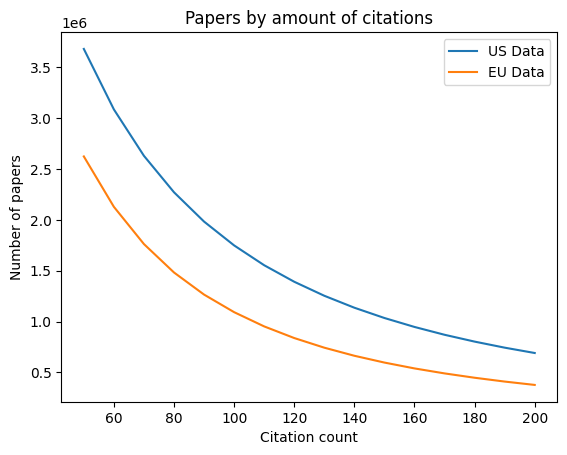

In [143]:
plt.plot(x,y, label= "US Data")
plt.plot(x2,y2, label= "EU Data")
plt.xlabel("Citation count")
plt.ylabel("Number of papers")
plt.title("Papers by amount of citations")
plt.legend()


### random sample as percentage of dataset?